In [1]:
# Reference
# https://yurimkoo.github.io/python/2019/09/14/connect-db-with-python.html

from dotenv import load_dotenv
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

os.chdir(os.path.dirname(os.getcwd()))

from functions.pubgapi import get_tournament_info
from functions.pubgapi import get_match_info
from functions.pubgapi import get_match_participant
from functions.pubgapi import get_match_participant_single
from functions.pubgapi import z_normalization

os.chdir("./example")

# Load api key & RDS info (endpoint="rds 엔드포인트", dbname="db 이름", username="마스터 사용자 이름", password="rds 비밀번호")
load_dotenv()
api_key = os.environ.get("API_KEY")
endpoint = os.environ.get("AWS_endpoint")
dbname = os.environ.get('AWS_dbname')
username = os.environ.get("AWS_username")
password = os.environ.get("AWS_password")

In [2]:
# 결측치 확인 함수
def print_missing_value(df):
    if (df.isnull().sum()).sum() != 0:
        raise Exception(f"Missing value: {(df.isnull().sum()).sum()}")

In [3]:
# tournament_info 불러오기
tournament_info = get_tournament_info(api_key)
print_missing_value(tournament_info)

# index 설정 및 해당 인덱스의 tournament_id 값 불러오기
tournament_index = 3
tournament_name = tournament_info["id"][tournament_index]
tournament_createdAt = tournament_info["createdAt"][tournament_index]

tournament_name

# cur_match_info(Current match info) 불러오기
cur_match_info = get_match_info(api_key, tournament_name)

# match_participant_single 불러오기
match_index = 5
match_participant_single = get_match_participant_single(api_key, cur_match_info["matchId"][match_index])
print_missing_value(match_participant_single)

# Z-score normalization 수행
data = z_normalization(match_participant_single)
print_missing_value(data)

'''
    해당 경로에 train_match_data.csv가 없으면, 파일 생성
    해당 경로에 train_match_data.csv가 있으면, 현재 내용을 해당 파일에 추가

'''

if os.path.isfile("./Train_data/train_match_data.csv"):
    # Load train_data & append new data(row)
    train_data = pd.read_csv(f"./Train_data/train_match_data.csv")
    train_data.drop(["Unnamed: 0"], axis = 1, inplace = True)

    train_data = pd.concat([train_data, data], ignore_index=True)
    train_data.to_csv(f"./Train_data/train_match_data.csv")
else:
    data.to_csv(f"./Train_data/train_match_data.csv")

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.850
특성 중요도 : 
[0.0548911  0.01638484 0.06956521 0.08537169 0.4838462  0.05074931
 0.05314418 0.03181454 0.         0.         0.15423292]


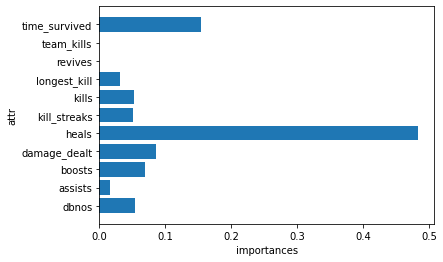

In [4]:
z_label = (["dbnos", "assists", "boosts", "damage_dealt", "heals", "kill_streaks", "kills", "longest_kill", "revives", "team_kills", "time_survived"])
X = data[z_label]
y = data["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train,y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test,y_test)))

print("특성 중요도 : \n{}".format(forest.feature_importances_))

# 특성 중요도 시각화 하기
def plot_feature_importances_cancer(model):
    n_features = len(z_label)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), z_label)
    plt.xlabel("importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances_cancer(forest)

In [5]:
mvp_feature = (forest.feature_importances_)*data[z_label]
data["mvp_feature"] = mvp_feature.sum(axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data.sort_values(["mvp_feature"], ascending=False)

,dbnos,assists,boosts,damage_dealt,heals,kill_streaks,kills,longest_kill,revives,team_kills,time_survived,win,mvp_feature
38,2.430987,3.668479,1.091842,2.719547,2.985298,2.202456,0.743398,1.864394,-0.424774,-0.258199,1.274725,0,2.353298
30,0.061700,-0.600297,0.694808,1.282731,3.300058,2.202456,1.432927,-0.184695,-0.424774,-0.258199,1.274725,1,2.126768
39,1.641225,2.245554,1.488875,2.447395,2.041019,2.202456,4.191041,2.020806,1.387595,-0.258199,1.274725,0,2.022331
36,0.061700,0.822629,1.488875,2.009969,2.670538,0.686787,0.743398,0.243071,-0.424774,-0.258199,1.161783,0,1.845443
37,4.010512,2.245554,1.091842,2.305773,1.411500,2.202456,4.191041,1.232585,3.199965,-0.258199,1.188217,0,1.769664
13,2.430987,-0.600297,0.297775,1.674098,1.096740,0.686787,1.432927,0.481104,-0.424774,-0.258199,1.176201,0,1.125614
15,0.851463,0.822629,1.091842,0.335315,1.411500,0.686787,0.743398,-0.123339,1.387595,3.872983,1.226665,0,1.107375
31,0.061700,-0.600297,1.488875,0.797381,1.096740,0.686787,0.743398,3.135931,1.387595,-0.258199,1.274725,1,1.066586
41,-0.728062,-0.600297,1.488875,-0.418056,1.726260,-0.828881,-0.635659,-0.552513,-0.424774,3.872983,0.693195,0,0.866817
27,1.641225,-0.600297,0.694808,2.023369,0.467221,0.686787,0.743398,1.638729,1.387595,-0.258199,1.041633,0,0.814540
